# Spatial indices: Urban sprawl

This notebook exemplifies the calculation of spatial urban sprawl indices, as shown in:
* [Calculating spatial urban sprawl indices using open data](https://hal.inria.fr/hal-01535469)



___"Urban sprawl is a phenomenon that can be visually perceived in the landscape. A landscape suffers from urban sprawl if it is permeated by urban development or solitary buildings and when land uptake per inhabitant or job is high. The more area built over and the more dispersed the build-up area, and the higher the land uptake per inhabitant or job (lower utilization intensity in the built-up area), the higher the degree of urban sprawl"___ [(Jaeger and Schwick 2014)](https://www.sciencedirect.com/science/article/pii/S1470160X13004858)

___"Urban sprawl or suburban sprawl describes the expansion of human populations away from central urban areas into low-density, monofunctional and usually car-dependent communities, in a process called suburbanization"___ [Wikipedia](https://en.wikipedia.org/wiki/Urban_sprawl)


### Characterization using three axes:
* Land use mix
* Accessibility
* Dispersion of the built-up area

In [1]:
# snippet for relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)

import matplotlib.pyplot as plt
import osmnx as ox
import urbansprawl as us

ox.config(log_file=True, log_console=True, log_name='spatial_indices-sprawl', log_filename='spatial_indices-sprawl', use_cache=True)
figsize = (12,8)

### Retrieve processed OSM data
* Lyon, France
* Data for this city has been previously processed and stored in the following notebook: [2-Spatial-indices-Land-use-mix](https://github.com/lgervasoni/urbansprawl/tree/master/examples/2-Spatial-indices-Land-use-mix.ipynb)

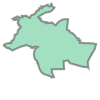

In [2]:
# Get shape for city
city_poly = ox.gdf_from_place("Lyon, France", which_result=1)
# Polygon
city_shape = city_poly.geometry[0]
city_shape

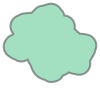

In [3]:
# Dilate the shape of the city to capture a bigger area
city_shape = city_shape.buffer(0.02)
west, south, east, north = city_shape.bounds
city_shape

In [4]:
# Retrieve OSM data : Lyon - Bounding box
city_ref = "Lyon_France"
region_args = {"north" : north, "west" : west, "south" : south, "east" : east}
%time df_osm_buildings, df_osm_building_parts, df_osm_pois = us.get_processed_osm_data(city_ref=city_ref, region_args=region_args)
%time osm_street_network = us.get_route_graph(city_ref)

CPU times: user 56min 46s, sys: 51 s, total: 57min 37s
Wall time: 57min 57s
CPU times: user 4.95 s, sys: 3.99 ms, total: 4.96 s
Wall time: 4.95 s


### Data visualization
* Buildings and their classified land use
    * Red: Activity uses
    * Blue: Residential uses
    * Green: Mixed-uses

(635817.4641914798, 649633.5892556852, 5060560.4116269825, 5077044.1303451555)

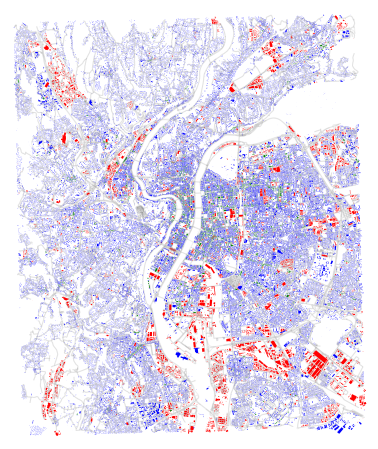

In [5]:
# Get buildings per classification
df_residential = df_osm_buildings[ df_osm_buildings.classification.isin(["residential"]) ]
df_activities = df_osm_buildings[ df_osm_buildings.classification.isin(["activity"]) ]
df_mixed = df_osm_buildings[ df_osm_buildings.classification.isin(["mixed"]) ]

# Plot
f, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0], edge_alpha=0.15, node_alpha=0, show=False, close=False)
# Buildings
if (not df_residential.empty):
    df_residential.plot(figsize=figsize, color="blue", ax=ax)
if (not df_activities.empty):
    df_activities.plot(figsize=figsize, color="red", ax=ax)
if (not df_mixed.empty):
    df_mixed.plot(figsize=figsize, color="green", ax=ax)
ax.axis('off')

### Spatial indices
* Indices are calculated on a regular grid
* For more details on the granularity of analysis, refer to the notebook [4-Spatial-indices-Granularity](https://github.com/lgervasoni/urbansprawl/tree/master/examples/4-Spatial-indices-Granularity.ipynb)

In [6]:
# Create a regular point-grid with step of 100 meters
step = 100
df_indices = us.get_indices_grid(df_osm_buildings, df_osm_building_parts, df_osm_pois, step=step)

### Land use mix
* ___"Urban sprawl or suburban sprawl describes the expansion of human populations away from central urban areas into [...] monofunctional [...] communities, in a process called suburbanization"___ [Wikipedia](https://en.wikipedia.org/wiki/Urban_sprawl)
* Land use mix denotes the degree of co-occurence of differing land uses within *walkable* distances.
    * A reduced mixed-use development (monofunctional uses) contributes to sprawl
* Formalization
    * Refer to the following notebook: [2-Spatial-indices-Land-use-mix](https://github.com/lgervasoni/urbansprawl/tree/master/examples/2-Spatial-indices-Land-use-mix.ipynb)

In [7]:
landusemix_args = {'walkable_distance': 600, 'compute_activity_types_kde': False, 'weighted_kde': False, 
                   'pois_weight': 9, 'log_weighted': True}
%time us.compute_grid_landusemix(df_indices, df_osm_buildings, df_osm_pois, landusemix_args)

CPU times: user 2min 46s, sys: 133 ms, total: 2min 46s
Wall time: 2min 46s


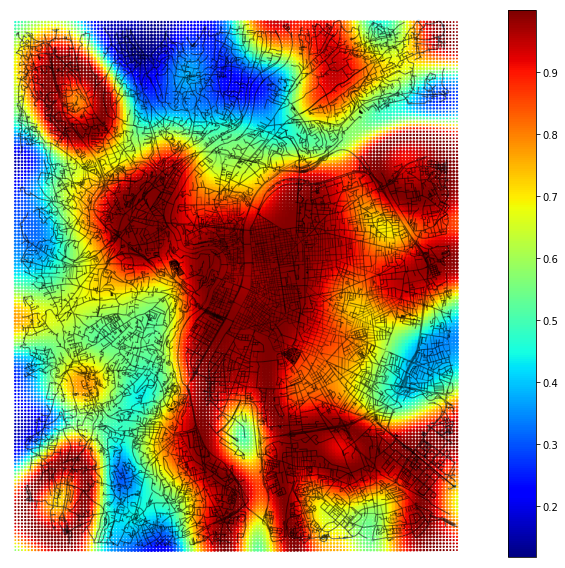

In [8]:
f, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.3, node_alpha=0.1)
df_indices.plot("landusemix", markersize=50*df_indices.landuse_intensity, figsize=figsize, cmap="jet", legend=True, ax=ax)
f.tight_layout()

### Accessibility
* ___"Urban sprawl or suburban sprawl describes the expansion of human populations away from central urban areas into [...] car-dependent communities, in a process called suburbanization"___ [Wikipedia](https://en.wikipedia.org/wiki/Urban_sprawl)
* Accessibility to activity opportunities determines the degree of automobile dependence in order to reach near-by activities takint into account the street network connectivity
    * Most often, journeys are made between residential and activity land uses (e.g. the basis of integrated Land use and transportation models)
    * Car-dependent communities contribute to sprawl
* Formalization
    * Fixed distance: Denotes the cumulative opportunities access to activity land uses given a fixed maximum distance to travel
        * The lower the degree of accessibility, the higher the degree of sprawl
    * Fixed activities: Represents the distance needed to travel in order to reach a certain number of activity land uses
        * The lower the degree of accessibility, the higher the degree of sprawl

In [9]:
accessibility_args = {'fixed_distance': True, 'fixed_activities': False, 'max_edge_length': 200, 
                      'max_node_distance': 250, 'fixed_distance_max_travel_distance': 2000, 
                      'fixed_distance_max_num_activities': 250, 'fixed_activities_min_number': 20}
%time us.compute_grid_accessibility(df_indices, osm_street_network, df_osm_buildings, df_osm_pois, accessibility_args)

CPU times: user 10.6 s, sys: 104 ms, total: 10.7 s
Wall time: 5h 5min 56s


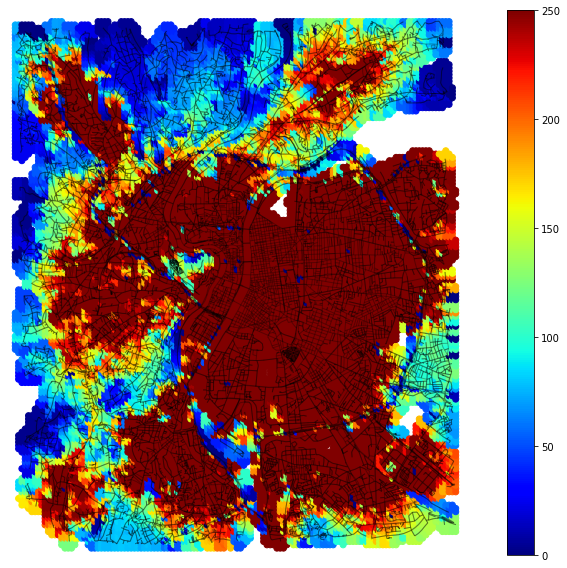

In [10]:
### Plot
f, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.3, node_alpha=0.1)
# For visualization purposes, set maximum value
ACC_MAX = accessibility_args["fixed_distance_max_num_activities"]
df_indices.plot("accessibility", figsize=figsize, cmap='jet', legend=True, ax=ax, vmin=0, vmax=ACC_MAX)
f.tight_layout()

### Dispersion of the built-up area
* ***"A landscape suffers from urban sprawl if it is permeated by urban development or solitary buildings [...]. The more area built over and the more dispersed the built-up area, [...] the higher the degree of urban sprawl"*** [(Jaeger and Schwick 2014)](https://www.sciencedirect.com/science/article/pii/S1470160X13004858)
* The dispersion of the built-up area denotes the degree of scatteredness of the built (i.e. buildings) environment
    * A high dispersion of the built-up environment contributes to sprawl
* Formalization
    * For each building, we measure the distance (meters) to its nearest neighboring building
        * For a given point in the grid, the dispersion is represented by the average or median of the computed distances including buildings within a local radius of search

In [11]:
dispersion_args = {'radius_search': 750, 'use_median': False, 'K_nearest': 50}
%time us.compute_grid_dispersion(df_indices, df_osm_buildings, dispersion_args)

CPU times: user 11min 29s, sys: 247 ms, total: 11min 29s
Wall time: 11min 29s


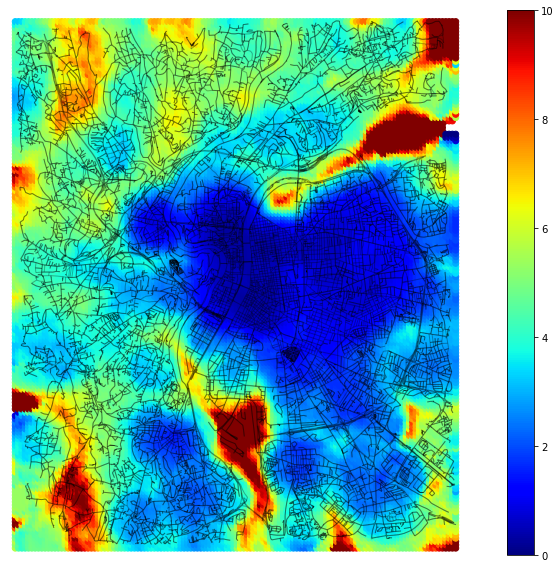

In [12]:
### Plot
f, ax = ox.plot_graph(osm_street_network, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.3, node_alpha=0.1)
# For visualization purposes, truncate maximum values
DISP_MAX = 10
df_indices.plot('dispersion', figsize=figsize, cmap='jet', legend=True, ax=ax, vmin=0, vmax=DISP_MAX)
f.tight_layout()